In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import imageio
import cv2
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet, MobileNetV2
from keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path
import os
import imageio

In [330]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet50 import ResNet50
from keras.layers import GaussianNoise

###   Load training data from npz array

In [120]:
train_ds = np.load('train.npz')
train_x = train_ds['arr_0']
train_y = train_ds['arr_1']

train_x.shape, train_y.shape

((1500, 784), (1500,))

194
195
197
198
203
208
215
223
233


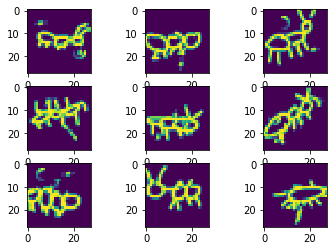

In [945]:
# number = random.randint(0, train_x.shape[0])
target = 1
fig, ax = plt.subplots(nrows=3, ncols=3)
number = 190
for row in ax:
    for col in row:
        
        while(train_y[number] != target):
            number +=1
        col.imshow(train_x[number].reshape(28, 28))
        print(number)
        number += 1

plt.show()

##### Function to save images (Needed for the flow_from_directory function from ImageDataGenerator).

In [133]:
def save_imgs(path:Path, data, labels):
    for label in np.unique(labels):
        (path/str(label)).mkdir(parents=True,exist_ok=True)
    for i in range(len(data)):
        if(len(labels)!=0):
            imageio.imwrite( str( path/str(labels[i])/(str(i)+'.jpg') ), data[i].reshape(28,28,3))
        else:
            imageio.imwrite( str( path/(str(i)+'.jpg') ), data[i])

### Constant validation set.

In [160]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [184]:
def flipImage(image):
    t = array_to_img(image.reshape(28,28,1), scale=True)
    t = np.stack((t,)*3, axis=-1).astype(np.uint8)
    t = tf.image.flip_left_right(np.array(t))
    arr = np.array(img_to_array(t))
    return arr.astype(np.uint8)
     

In [871]:
indexValid = np.concatenate((np.where(train_y == 0)[0][200:], np.where(train_y == 1)[0][200:], np.where(train_y == 2)[0][200:], np.where(train_y == 3)[0][200:], np.where(train_y == 4)[0][200:], np.where(train_y == 5)[0][200:]))
indexValid.shape

(300,)

In [872]:
indexTrain = np.concatenate((np.where(train_y == 0)[0][:200], np.where(train_y == 1)[0][:200], np.where(train_y == 2)[0][:200], np.where(train_y == 3)[0][:200], np.where(train_y == 4)[0][:200], np.where(train_y == 5)[0][:200]))
indexTrain.shape

(1200,)

####  Validation labels encoding, doubled because we flip the images.

In [873]:
enc = OneHotEncoder()
enc.fit(train_y[indexValid].reshape(-1,1))
yValid = enc.transform(train_y[indexValid].reshape(-1,1)).toarray()
yValid.shape

(300, 6)

In [874]:
yValid = np.concatenate((yValid, yValid))

#### Training Labels Encoding. *(If needed).

In [876]:
enc = OneHotEncoder()
enc.fit(train_y[indexTrain].reshape(-1,1))
yT = enc.transform(train_y[indexTrain].reshape(-1,1)).toarray()
yT.shape

(1200, 6)

In [877]:
yT = np.concatenate((yT, yT))

In [878]:
def change_size(image):
    img = array_to_img(image, scale=True) #returns PIL Image
    img = img.resize((128, 128)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = np.array(img_to_array(img)) #convert back to array
    return arr.astype(np.uint8)

#### Validation set Flipping and Resizing to fit the MobileNet Network

In [879]:
xV = train_x[indexValid]
xValid = np.zeros((600,  128, 128 ,3))
for i in range(300):
    #xValid[i] = np.stack((xV[i].reshape(28,28),)*3, axis=-1)
    xValid[i] = change_size(xV[i].reshape(28,28,1))
for i in range(300):
    t = flipImage(xV[i]).reshape(28,28,3)
    xValid[i+300] = change_size(t)

#### Same for training set. *(if needed).

In [880]:
xT = train_x[indexTrain]
xTrain = np.zeros((2400,  28, 28 ,3))

for i in range(1200):
    xTrain[i] = np.stack((xT[i].reshape(28,28),)*3, axis=-1)
    
for i in range(1200):
    t = flipImage(xT[i].reshape(28,28))
    xTrain[i+1200] = t

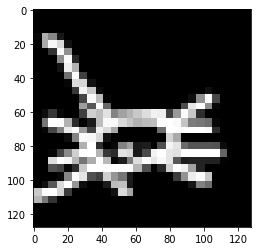

In [881]:
plt.imshow(xValid[300] / 255)

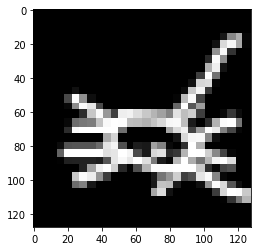

In [882]:
plt.imshow(xValid[0]/255)

##### A bit ugly but it should be better for the preprocessing of the inputs.

In [883]:
xValid.shape

(600, 128, 128, 3)

### Saving Training Data to directory if not already done.  Skip if otherwise.

###### Reshaping and saving training data to directory.

In [884]:
trainingSplit = 1200

In [885]:
X_train = np.stack((train_x,)*3, axis=-1).astype(np.uint8)
print(X_train.shape)

(1500, 784, 3)


In [886]:
indexTrain = np.concatenate((np.where(train_y == 0)[0][:200], np.where(train_y == 1)[0][:200], np.where(train_y == 2)[0][:200], np.where(train_y == 3)[0][:200], np.where(train_y == 4)[0][:200], np.where(train_y == 5)[0][:200]))
indexTrain.shape

(1200,)

In [887]:
X_train[indexTrain].shape

(1200, 784, 3)

In [888]:
save_imgs(Path('./train1200Classes/classes'), X_train[indexTrain], train_y[indexTrain])

In [869]:
indexValid = np.concatenate((np.where(train_y == 0)[0][200:], np.where(train_y == 1)[0][200:], np.where(train_y == 2)[0][200:], np.where(train_y == 3)[0][200:], np.where(train_y == 4)[0][200:], np.where(train_y == 5)[0][200:]))
indexValid.shape

(300,)

#### We should optimize buy having a fully balanced training_set, which the case now: 

In [870]:
t = train_y[indexTrain]
count = np.zeros(6)
for i in t:
    count[i] += 1
print(count)

[200. 200. 200. 200. 200. 200.]


### Load Test Data, if we already have them on disc in the good format, you can skip part 1.

#### Part 1

In [7]:
## Not Needed if we already have them on disc with the call (np.load('test128RGB.npy')).
test_ds = np.load('test.npz')
test_x = test_ds['arr_0']

test_x.shape

(60000, 784)

In [763]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [762]:
def change_size(image):
    img = array_to_img(image, scale=True) #returns PIL Image
    img = img.resize((128, 128)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = np.array(img_to_array(img)) #convert back to array
    return arr.astype(np.uint8)

#### Resizing the test data.

In [ ]:
X_train = np.stack((train_x,)*3, axis=-1).astype(np.uint8)
print(X_train.shape)

In [768]:
testReshapedX = np.zeros((test_x.shape[0], 128,  128, 3))
X_test = np.stack((test_x,)*3, axis=-1).astype(np.uint8)
percentage =  60000 /100
p = 1
for i in range(X_test.shape[0]):
    testReshapedX[i] = change_size(X_test[i].reshape(28,28,3))
    if i % percentage == 0:
        print(p, "%")
        p +=1
    

1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


#### Saving  the data in case of crash.

In [ ]:
np.save("test128RGB.npy", testReshapedX.astype(np.uint8))

In [ ]:
testReshapedX.shape

##### Part 2

In [9]:
## Cannot be done if not on disc. (Should load them from the above call).
testReshapedX = np.load('test128RGB.npy')
testReshapedX.shape

(60000, 128, 128, 3)

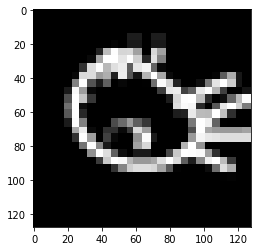

In [22]:
plt.imshow(testReshapedX[30000] /255)  

### MobileNet Transfer Modle

##### Prepocess the validation set. * I often made mistakes because of that haha.

In [896]:
xValid = keras.applications.mobilenet.preprocess_input(xValid)

In [897]:
xValid[0].max()

1.0

In [675]:
xValid.shape

(600, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


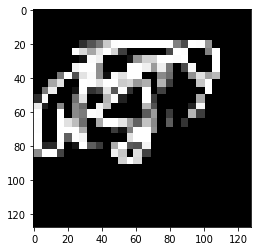

In [788]:
plt.imshow(xValid[0] )

#### Train Image Generator, from the directory created above.

In [804]:
from keras.applications import MobileNet, MobileNetV2

In [889]:
from keras.applications.resnet50 import preprocess_input
import tensorflow as tf

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True, width_shift_range=0.17, zoom_range=0.1,
    height_shift_range=0.17, shear_range=0.01, rotation_range=25, fill_mode="constant", validation_split=0.00)
train_generator = train_datagen.flow_from_directory('./train1200Classes/classes', class_mode='categorical', target_size=(128,128), subset='training')
#valid_generator = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(128,128), subset='validation')

Found 1200 images belonging to 6 classes.


In [890]:
## Checking
x, y = train_generator[0]
print(x.shape)
print(y.shape)

(32, 128, 128, 3)
(32, 6)


In [891]:
x[22].max()

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


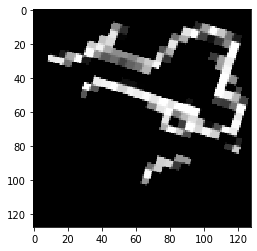

In [899]:
plt.imshow(x[22])

In [814]:
x.shape

(32, 128, 128, 3)

### Model, not sure whether to freeze the upper model. Currently, don't think we should.

In [920]:
model = Sequential()


model.add(MobileNet(input_shape=(128,128, 3),  include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation = 'softmax'))

model.layers[0].trainable = False

In [921]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 1024)              3228864   
_________________________________________________________________
dropout_45 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_101 (Dense)            (None, 6)                 774       
Total params: 3,360,838
Trainable params: 131,974
Non-trainable params: 3,228,864
_________________________________________________________________


### Unfreeze the model.

In [922]:
model.trainable = True
model.layers[0].trainable = True
model.layers[1].trainable = True

In [923]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 1024)              3228864   
_________________________________________________________________
dropout_45 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_101 (Dense)            (None, 6)                 774       
Total params: 3,360,838
Trainable params: 3,338,950
Non-trainable params: 21,888
_________________________________________________________________


### Compile with very small learning rate.

In [924]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [925]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.fit_generator(generator=train_generator,epochs=1000,validation_data=(xValid , yValid), callbacks=[callback])

Epoch 1/1000
38/38 [==============================] - 51s 1s/step - loss: 3.0965 - accuracy: 0.1725 - val_loss: 2.5192 - val_accuracy: 0.2133
Epoch 2/1000
38/38 [==============================] - 45s 1s/step - loss: 2.6424 - accuracy: 0.2033 - val_loss: 2.1494 - val_accuracy: 0.2067
Epoch 3/1000
38/38 [==============================] - 45s 1s/step - loss: 2.3856 - accuracy: 0.2283 - val_loss: 1.8849 - val_accuracy: 0.2283
Epoch 4/1000
38/38 [==============================] - 45s 1s/step - loss: 2.0986 - accuracy: 0.2650 - val_loss: 1.7334 - val_accuracy: 0.2950
Epoch 5/1000
38/38 [==============================] - 45s 1s/step - loss: 1.8733 - accuracy: 0.3167 - val_loss: 1.6675 - val_accuracy: 0.3483
Epoch 6/1000
38/38 [==============================] - 55s 1s/step - loss: 1.7762 - accuracy: 0.3492 - val_loss: 1.6131 - val_accuracy: 0.3567
Epoch 7/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7431 - accuracy: 0.3742 - val_loss: 1.5699 - val_accuracy: 0.3733
Epoch 

38/38 [==============================] - 41s 1s/step - loss: 0.3809 - accuracy: 0.8642 - val_loss: 0.4589 - val_accuracy: 0.8550
Epoch 116/1000
38/38 [==============================] - 41s 1s/step - loss: 0.3783 - accuracy: 0.8675 - val_loss: 0.4653 - val_accuracy: 0.8583
Epoch 117/1000
38/38 [==============================] - 41s 1s/step - loss: 0.3967 - accuracy: 0.8600 - val_loss: 0.4533 - val_accuracy: 0.8533
Epoch 118/1000
38/38 [==============================] - 42s 1s/step - loss: 0.3751 - accuracy: 0.8692 - val_loss: 0.4532 - val_accuracy: 0.8533
Epoch 119/1000
38/38 [==============================] - 40s 1s/step - loss: 0.3940 - accuracy: 0.8483 - val_loss: 0.4567 - val_accuracy: 0.8567
Epoch 120/1000
38/38 [==============================] - 40s 1s/step - loss: 0.3635 - accuracy: 0.8675 - val_loss: 0.4489 - val_accuracy: 0.8600
Epoch 121/1000
38/38 [==============================] - 40s 1s/step - loss: 0.3706 - accuracy: 0.8683 - val_loss: 0.4462 - val_accuracy: 0.8617
Epoch 1

Epoch 172/1000
38/38 [==============================] - 49s 1s/step - loss: 0.2234 - accuracy: 0.9200 - val_loss: 0.3998 - val_accuracy: 0.8850
Epoch 173/1000
38/38 [==============================] - 44s 1s/step - loss: 0.2748 - accuracy: 0.9000 - val_loss: 0.3973 - val_accuracy: 0.8883
Epoch 174/1000
38/38 [==============================] - 45s 1s/step - loss: 0.2324 - accuracy: 0.9225 - val_loss: 0.3955 - val_accuracy: 0.8850
Epoch 175/1000
38/38 [==============================] - 42s 1s/step - loss: 0.2316 - accuracy: 0.9208 - val_loss: 0.3914 - val_accuracy: 0.8850
Epoch 176/1000
38/38 [==============================] - 44s 1s/step - loss: 0.2093 - accuracy: 0.9292 - val_loss: 0.3891 - val_accuracy: 0.8850
Epoch 177/1000
38/38 [==============================] - 41s 1s/step - loss: 0.2261 - accuracy: 0.9267 - val_loss: 0.3883 - val_accuracy: 0.8883
Epoch 178/1000
38/38 [==============================] - 41s 1s/step - loss: 0.2605 - accuracy: 0.9058 - val_loss: 0.4044 - val_accuracy:

In [928]:
import tensorflow as tf

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True, width_shift_range=0.17, zoom_range=0.1,
    height_shift_range=0.18, shear_range=0.01, rotation_range=35, fill_mode="constant", validation_split=0.00)
train_generator2 = train_datagen.flow_from_directory('./train1200Classes/classes', class_mode='categorical', target_size=(128,128), subset='training')
#valid_generator = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(128,128), subset='validation')

Found 1200 images belonging to 6 classes.


In [929]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model.fit_generator(generator=train_generator2,epochs=1000,validation_data=(xValid , yValid), callbacks=[callback])

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 0.3153 - accuracy: 0.8900 - val_loss: 0.3824 - val_accuracy: 0.8850
Epoch 2/1000
38/38 [==============================] - 43s 1s/step - loss: 0.2891 - accuracy: 0.9008 - val_loss: 0.3864 - val_accuracy: 0.8900
Epoch 3/1000
38/38 [==============================] - 42s 1s/step - loss: 0.3134 - accuracy: 0.8858 - val_loss: 0.3940 - val_accuracy: 0.8850
Epoch 4/1000
38/38 [==============================] - 42s 1s/step - loss: 0.3397 - accuracy: 0.8675 - val_loss: 0.3990 - val_accuracy: 0.8817
Epoch 5/1000
38/38 [==============================] - 42s 1s/step - loss: 0.2874 - accuracy: 0.8958 - val_loss: 0.4040 - val_accuracy: 0.8783
Epoch 6/1000
38/38 [==============================] - 45s 1s/step - loss: 0.2818 - accuracy: 0.8958 - val_loss: 0.4016 - val_accuracy: 0.8767
Epoch 7/1000
38/38 [==============================] - 46s 1s/step - loss: 0.3305 - accuracy: 0.8792 - val_loss: 0.4126 - val_accuracy: 0.8717


In [833]:
import tensorflow as tf

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True, width_shift_range=0.22, zoom_range=0.1,
    height_shift_range=0.22, shear_range=0.01, rotation_range=45, fill_mode="constant", validation_split=0.00)
train_generator3 = train_datagen.flow_from_directory('./train1200Classes/Classes', class_mode='categorical', target_size=(128,128), subset='training')
#valid_generator = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(128,128), subset='validation')

Found 1200 images belonging to 6 classes.


In [911]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model.fit_generator(generator=train_generator3,epochs=1000,validation_data=(xValid , yValid), callbacks=[callback])

Epoch 1/1000
38/38 [==============================] - 41s 1s/step - loss: 0.3497 - accuracy: 0.8717 - val_loss: 0.3706 - val_accuracy: 0.8833
Epoch 2/1000
38/38 [==============================] - 42s 1s/step - loss: 0.3969 - accuracy: 0.8567 - val_loss: 0.3763 - val_accuracy: 0.8833
Epoch 3/1000
38/38 [==============================] - 49s 1s/step - loss: 0.4130 - accuracy: 0.8575 - val_loss: 0.3750 - val_accuracy: 0.8850
Epoch 4/1000
38/38 [==============================] - 44s 1s/step - loss: 0.4105 - accuracy: 0.8517 - val_loss: 0.3763 - val_accuracy: 0.8817
Epoch 5/1000
38/38 [==============================] - 43s 1s/step - loss: 0.3744 - accuracy: 0.8558 - val_loss: 0.3713 - val_accuracy: 0.8850
Epoch 6/1000
38/38 [==============================] - 43s 1s/step - loss: 0.3884 - accuracy: 0.8658 - val_loss: 0.3635 - val_accuracy: 0.8850
Epoch 7/1000
38/38 [==============================] - 42s 1s/step - loss: 0.3691 - accuracy: 0.8692 - val_loss: 0.3637 - val_accuracy: 0.8817
Epoch 

### Following might be a bit risky, training only on validation data. (Maybe we should do it in anothe image data generator to avoiid overfiting.

In [754]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(xValid , yValid,epochs=2, callbacks=[callback])

Epoch 1/10
19/19 [==============================] - 18s 943ms/step - loss: 0.1653 - accuracy: 0.9450
Epoch 2/10
19/19 [==============================] - 18s 948ms/step - loss: 0.1516 - accuracy: 0.9533
Epoch 3/10
19/19 [==============================] - 18s 949ms/step - loss: 0.1266 - accuracy: 0.9600
Epoch 4/10
19/19 [==============================] - 17s 907ms/step - loss: 0.1058 - accuracy: 0.9633
Epoch 5/10
19/19 [==============================] - 17s 918ms/step - loss: 0.1020 - accuracy: 0.9667
Epoch 6/10
19/19 [==============================] - 17s 920ms/step - loss: 0.1045 - accuracy: 0.9717
Epoch 7/10
19/19 [==============================] - 18s 931ms/step - loss: 0.0837 - accuracy: 0.9883
Epoch 8/10
19/19 [==============================] - 17s 915ms/step - loss: 0.0667 - accuracy: 0.9767
Epoch 9/10
19/19 [==============================] - 18s 973ms/step - loss: 0.0851 - accuracy: 0.9833
Epoch 10/10
19/19 [==============================] - 19s 974ms/step - loss: 0.0701 - accura

#### Save the model

In [926]:
model.save_weights('./checkpoints/my_checkpoint')

In [946]:
!mkdir -p saved_model
model.save('saved_model/my_model8')

INFO:tensorflow:Assets written to: saved_model/my_model8/assets


INFO:tensorflow:Assets written to: saved_model/my_model8/assets


#### Load the saved model (If wanted).

In [ ]:
mo1 = keras.models.load_model('saved_model/my_model4')

#### Preprocess the test set to fit the one passed with the training set. 

In [ ]:
reshapedTestPreprocessed = keras.applications.mobilenet.preprocess_input(testReshapedX)

#### Make predictions

In [933]:
p6 = model.predict(reshapedTestPreprocessed)

#### Check the uniformity.

In [932]:
p5

array([[3.5366074e-06, 1.0109969e-05, 9.9997783e-01, 1.7497619e-07,
        4.3879591e-06, 4.0033797e-06],
       [7.8312763e-07, 3.7874979e-06, 9.9999499e-01, 2.7511371e-09,
        2.5645474e-07, 1.9849668e-07],
       [8.1936613e-04, 3.5620792e-04, 1.2101792e-03, 3.1458385e-02,
        9.6198946e-01, 4.1663754e-03],
       ...,
       [7.8578756e-07, 2.0418297e-04, 3.2544065e-06, 2.2660107e-08,
        7.9142546e-06, 9.9978381e-01],
       [1.7275155e-04, 3.8914832e-01, 1.2770750e-01, 7.5033848e-04,
        4.6253806e-01, 1.9683031e-02],
       [1.4065078e-02, 1.2698229e-03, 3.5135562e-03, 1.1184219e-02,
        9.6800953e-01, 1.9577942e-03]], dtype=float32)

In [938]:
count = np.zeros(6)
for i in p6:
    count[np.argmax(i)] += 1
print(count)

[ 9032.  9962. 10546. 10299. 10340.  9821.]


In [837]:
count = np.zeros(6)
for i in p5:
    count[np.argmax(i)] += 1
print(count)

[ 9796. 10292. 10241. 10205.  9648.  9818.]


In [913]:
count = np.zeros(6)
for i in p5:
    count[np.argmax(i)] += 1
print(count)

[ 9557.  9669. 10183.  9625. 10709. 10257.]


In [935]:
predictions = np.argmax(p6,  axis=1)
pred6 = pd.DataFrame(predictions)
pred6.index.name = "Id"
pred6 = pred6.rename(columns={0: "Category"})


In [936]:
pred6[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,1
5,2
6,2
7,4
8,5


In [915]:
pred5[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,2
5,2
6,2
7,4
8,5


In [839]:
pred5[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,1
5,2
6,2
7,4
8,5


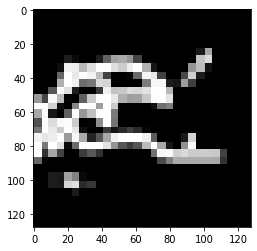

In [937]:
plt.imshow(testReshapedX[14]/255)

#### Output CSV

In [939]:
pred6.to_csv('mobileNetTransferPredictions6.csv')

### Le reste est un bit gibberish mais je vais les garder juste pour que je me retrouve haha et me donner une baseline.

In [733]:
count = np.zeros(6)
for i in p:
    count[np.argmax(i)] += 1
print(count)

[ 8223. 10101. 10083.  8820. 11698. 11075.]


In [731]:
count = np.zeros(6)
for i in p:
    count[np.argmax(i)] += 1
print(count)

[ 9502.  9781. 10185. 10192. 10757.  9583.]


In [745]:
count = np.zeros(6)
for i in p2:
    count[np.argmax(i)] += 1
print(count)

[ 9618.  8898.  9717.  9593. 11937. 10237.]


In [746]:
predictions = np.argmax(p2,  axis=1)
pred2 = pd.DataFrame(predictions)
pred2.index.name = "Id"
pred2 = pred2.rename(columns={0: "Category"})


In [846]:
pred5[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,1
5,2
6,2
7,4
8,5


In [739]:
preds[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,4
5,2
6,2
7,4
8,5


In [710]:
predictions = np.argmax(p,  axis=1)
pred = pd.DataFrame(predictions)
pred.index.name = "Id"
pred = pred.rename(columns={0: "Category"})


In [749]:
pred[:9]

,Category
Id,
0,2
1,2
2,4
3,0
4,2
5,2
6,2
7,4
8,3


In [697]:
pred[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,4
5,2
6,2
7,4
8,5


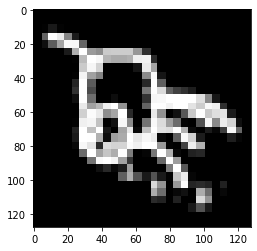

In [750]:
plt.imshow(testReshapedX[9])

In [753]:
preds.to_csv('mobileNetTransferPredictions2.csv')

# MNIST

In [318]:
import pickle
import numpy as np
import gzip


def one_hot(y, n_classes=6):
    return np.eye(n_classes)[y]

def load_mnist():
    data_file = gzip.open("mnist.pkl.gz", "rb")
    train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
    data_file.close()

    train_inputs = [np.reshape(x, (784, 1)) for x in train_data[0]]
    train_results = [one_hot(y, 10) for y in train_data[1]]
    train_data = np.array(train_inputs).reshape(-1, 784), np.array(train_results).reshape(-1, 10)

    val_inputs = [np.reshape(x, (784, 1)) for x in val_data[0]]
    val_results = [one_hot(y, 10) for y in val_data[1]]
    val_data = np.array(val_inputs).reshape(-1, 784), np.array(val_results).reshape(-1, 10)

    test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
    test_data = list(zip(test_inputs, test_data[1]))

    return train_data, val_data, test_data

In [319]:
trainM, valM, testM = load_mnist()

In [320]:
trainM_x, trainMy = trainM
validM_x, validMy = valM

In [321]:
trainM_x.shape

(50000, 784)

In [322]:
trainM_y = np.argmax(trainMy, axis=1)
validM_y = np.argmax(validMy,  axis=1)

In [323]:
result = np.where((trainM_y > 3))[0]
resultV = np.where((validM_y > 3))[0]

In [385]:
trainMX = trainM_x[result] 
trainMY = one_hot(trainM_y[result]-4) 

validMX = validM_x[resultV] 
validMY = one_hot(validM_y[resultV]-4)

trainMX = trainMX.reshape(-1, 28, 28, 1)
validMX = validMX.reshape(-1, 28, 28, 1)


trainMX = np.stack((trainMX.reshape(-1, 28,28),)*3, axis=-1)
validMX = np.stack((validMX.reshape(-1, 28,28),)*3, axis=-1)

In [383]:
trainMX.shape

(29321, 28, 28, 3)

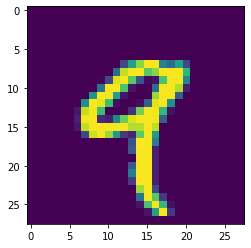

In [376]:
plt.imshow(trainMX[2].reshape(28,28))

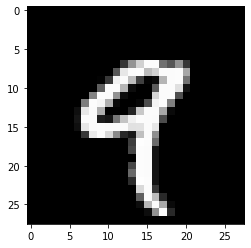

In [384]:
plt.imshow(trainMX[2])

In [568]:
from keras.layers.normalization import BatchNormalization

In [614]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [615]:
m = cnn_model()
m.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)              

In [616]:
m.fit(trainMX, trainMY,
          epochs=6,
          batch_size=32,
          validation_data=(validMX, validMY))

Epoch 1/6
917/917 [==============================] - 16s 18ms/step - loss: 0.2280 - accuracy: 0.9203 - val_loss: 0.0742 - val_accuracy: 0.9796
Epoch 2/6
917/917 [==============================] - 16s 18ms/step - loss: 0.0636 - accuracy: 0.9800 - val_loss: 0.0459 - val_accuracy: 0.9863
Epoch 3/6
917/917 [==============================] - 17s 19ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.0512 - val_accuracy: 0.9855
Epoch 4/6
917/917 [==============================] - 13s 15ms/step - loss: 0.0352 - accuracy: 0.9885 - val_loss: 0.0411 - val_accuracy: 0.9884
Epoch 5/6
917/917 [==============================] - 14s 15ms/step - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.0586 - val_accuracy: 0.9840
Epoch 6/6
917/917 [==============================] - 14s 16ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.0700 - val_accuracy: 0.9831


In [617]:
m.trainable = True

In [618]:
for (idx, l) in enumerate(m.layers):  
    l.trainable = False
    if idx > 4:
        l.trainable = True

In [619]:
m.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)              

In [620]:

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True, width_shift_range=0.1, zoom_range=0.1,
    height_shift_range=0.1, shear_range=0.01, rotation_range=15, fill_mode="constant", rescale=1./255, validation_split=0.00)
train_gen = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(28,28), subset='training')
valid_gen = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(28,28), subset='validation')

Found 1200 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [621]:
x, y = train_generator[0]
print(x.shape)
print(y.shape)

(32, 28, 28, 3)
(32, 6)


In [622]:
print(y[21])

[0. 1. 0. 0. 0. 0.]


In [623]:
trainMX[21].max()

0.99609375

In [578]:
x[21].max()

0.99762714

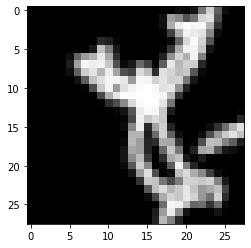

In [597]:
plt.imshow(x[20])  

In [580]:
xValid.shape

(600, 28, 28, 3)

In [581]:
yValid.shape

(600, 6)

In [605]:
# datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#         rotation_range=15,
#         width_shift_range=0.15,
#         height_shift_range=0.15,
#         shear_range=0.00,
#         zoom_range=0.1,
#         rescale=1./255,
#         horizontal_flip=True,
#         fill_mode='constant')

In [606]:
# it = datagen.flow(xTrain, yT, batch_size=32)

In [607]:
# x, y = it[0]
# x.shape

(32, 28, 28, 3)

In [624]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
m.fit_generator(generator=train_generator,epochs=100, validation_data=(xValid /255, yValid), callbacks=[callback])


Epoch 1/100
38/38 [==============================] - 2s 46ms/step - loss: 2.0956 - accuracy: 0.2217 - val_loss: 1.7477 - val_accuracy: 0.2567
Epoch 2/100
38/38 [==============================] - 1s 37ms/step - loss: 1.6888 - accuracy: 0.2808 - val_loss: 1.6232 - val_accuracy: 0.3317
Epoch 3/100
38/38 [==============================] - 1s 37ms/step - loss: 1.6038 - accuracy: 0.3225 - val_loss: 1.5808 - val_accuracy: 0.3700
Epoch 4/100
38/38 [==============================] - 1s 38ms/step - loss: 1.5128 - accuracy: 0.3542 - val_loss: 1.4620 - val_accuracy: 0.3733
Epoch 5/100
38/38 [==============================] - 1s 37ms/step - loss: 1.4694 - accuracy: 0.3858 - val_loss: 1.4510 - val_accuracy: 0.4317
Epoch 6/100
38/38 [==============================] - 1s 34ms/step - loss: 1.4153 - accuracy: 0.4192 - val_loss: 1.3898 - val_accuracy: 0.4450
Epoch 7/100
38/38 [==============================] - 1s 35ms/step - loss: 1.4094 - accuracy: 0.4258 - val_loss: 1.3894 - val_accuracy: 0.4450
Epoch 

In [563]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
m.fit_generator(generator=train_generator,epochs=100, validation_data=(xValid /255, yValid), callbacks=[callback])


Epoch 1/100
38/38 [==============================] - 2s 42ms/step - loss: 0.5486 - accuracy: 0.8092 - val_loss: 0.7434 - val_accuracy: 0.7967
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 0.5189 - accuracy: 0.8058 - val_loss: 0.7437 - val_accuracy: 0.7967
Epoch 3/100
38/38 [==============================] - 2s 41ms/step - loss: 0.4819 - accuracy: 0.8192 - val_loss: 0.7436 - val_accuracy: 0.7967
Epoch 4/100
38/38 [==============================] - 2s 41ms/step - loss: 0.5141 - accuracy: 0.8125 - val_loss: 0.7441 - val_accuracy: 0.7967
Epoch 5/100
38/38 [==============================] - 2s 40ms/step - loss: 0.4834 - accuracy: 0.8267 - val_loss: 0.7445 - val_accuracy: 0.7967
Epoch 6/100
38/38 [==============================] - 2s 40ms/step - loss: 0.5031 - accuracy: 0.8258 - val_loss: 0.7449 - val_accuracy: 0.7983
Epoch 7/100
38/38 [==============================] - 1s 39ms/step - loss: 0.5409 - accuracy: 0.8100 - val_loss: 0.7448 - val_accuracy: 0.7950
Epoch 

KeyboardInterrupt: 

In [565]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
m.fit_generator(generator=train_generator,epochs=100, validation_data=(xValid /255, yValid), callbacks=[callback])


Epoch 1/100
38/38 [==============================] - 3s 83ms/step - loss: 0.5813 - accuracy: 0.7992 - val_loss: 0.7052 - val_accuracy: 0.7817
Epoch 2/100
38/38 [==============================] - 3s 66ms/step - loss: 0.5238 - accuracy: 0.8050 - val_loss: 0.9033 - val_accuracy: 0.7617
Epoch 3/100
38/38 [==============================] - 3s 75ms/step - loss: 0.5812 - accuracy: 0.8033 - val_loss: 0.8731 - val_accuracy: 0.7633
Epoch 4/100
38/38 [==============================] - 3s 72ms/step - loss: 0.5326 - accuracy: 0.8058 - val_loss: 0.7914 - val_accuracy: 0.7850
Epoch 5/100
38/38 [==============================] - 3s 73ms/step - loss: 0.5536 - accuracy: 0.8000 - val_loss: 0.7891 - val_accuracy: 0.7683
Epoch 6/100
38/38 [==============================] - 3s 74ms/step - loss: 0.5305 - accuracy: 0.8150 - val_loss: 0.7104 - val_accuracy: 0.7800
Epoch 7/100
38/38 [==============================] - 3s 74ms/step - loss: 0.5152 - accuracy: 0.8133 - val_loss: 0.7752 - val_accuracy: 0.7867
Epoch 

KeyboardInterrupt: 

In [564]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [546]:
m.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [561]:
m.fit_generator(generator=train_generator,epochs=100, validation_data=(xValid /255, yValid), callbacks=[])


Epoch 1/100
38/38 [==============================] - 2s 40ms/step - loss: 0.5116 - accuracy: 0.8092 - val_loss: 0.7589 - val_accuracy: 0.7900
Epoch 2/100
38/38 [==============================] - 1s 35ms/step - loss: 0.5315 - accuracy: 0.8108 - val_loss: 0.7586 - val_accuracy: 0.7917
Epoch 3/100
38/38 [==============================] - 2s 40ms/step - loss: 0.5319 - accuracy: 0.7992 - val_loss: 0.7581 - val_accuracy: 0.7900
Epoch 4/100
38/38 [==============================] - 1s 37ms/step - loss: 0.5352 - accuracy: 0.8108 - val_loss: 0.7575 - val_accuracy: 0.7883
Epoch 5/100
38/38 [==============================] - 1s 39ms/step - loss: 0.5630 - accuracy: 0.8117 - val_loss: 0.7569 - val_accuracy: 0.7900
Epoch 6/100
38/38 [==============================] - 1s 37ms/step - loss: 0.5275 - accuracy: 0.8058 - val_loss: 0.7563 - val_accuracy: 0.7900
Epoch 7/100
38/38 [==============================] - 1s 38ms/step - loss: 0.5299 - accuracy: 0.8117 - val_loss: 0.7555 - val_accuracy: 0.7900
Epoch 

In [562]:
m.fit_generator(generator=train_generator,epochs=100, validation_data=(xValid /255, yValid), callbacks=[])


Epoch 1/100
38/38 [==============================] - 2s 44ms/step - loss: 0.5206 - accuracy: 0.8242 - val_loss: 0.7482 - val_accuracy: 0.8000
Epoch 2/100
38/38 [==============================] - 1s 39ms/step - loss: 0.5441 - accuracy: 0.8108 - val_loss: 0.7487 - val_accuracy: 0.8000
Epoch 3/100
38/38 [==============================] - 2s 40ms/step - loss: 0.5526 - accuracy: 0.8000 - val_loss: 0.7485 - val_accuracy: 0.8000
Epoch 4/100
38/38 [==============================] - 1s 39ms/step - loss: 0.5348 - accuracy: 0.8017 - val_loss: 0.7481 - val_accuracy: 0.8000
Epoch 5/100
38/38 [==============================] - 1s 39ms/step - loss: 0.5068 - accuracy: 0.8192 - val_loss: 0.7483 - val_accuracy: 0.8000
Epoch 6/100
38/38 [==============================] - 2s 41ms/step - loss: 0.5073 - accuracy: 0.8133 - val_loss: 0.7482 - val_accuracy: 0.8000
Epoch 7/100
38/38 [==============================] - 2s 43ms/step - loss: 0.5540 - accuracy: 0.8175 - val_loss: 0.7480 - val_accuracy: 0.8000
Epoch 

In [550]:
m.trainable = True
for (idx, l) in enumerate(m.layers):  

    if idx > 0:
        l.trainable = True

In [551]:
m.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 128)       262272    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               409728    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)             

In [518]:
m.fit_generator(generator=train_generator,epochs=10, validation_data=(xValid /255, yValid), callbacks=[])


Epoch 1/10
38/38 [==============================] - 2s 40ms/step - loss: 0.6724 - accuracy: 0.7583 - val_loss: 0.6507 - val_accuracy: 0.7983
Epoch 2/10
38/38 [==============================] - 1s 35ms/step - loss: 0.6775 - accuracy: 0.7558 - val_loss: 0.6510 - val_accuracy: 0.7983
Epoch 3/10
38/38 [==============================] - 1s 34ms/step - loss: 0.7032 - accuracy: 0.7375 - val_loss: 0.6513 - val_accuracy: 0.7983
Epoch 4/10
38/38 [==============================] - 1s 31ms/step - loss: 0.6677 - accuracy: 0.7533 - val_loss: 0.6510 - val_accuracy: 0.7983
Epoch 5/10
38/38 [==============================] - 1s 36ms/step - loss: 0.6757 - accuracy: 0.7542 - val_loss: 0.6511 - val_accuracy: 0.7967
Epoch 6/10
38/38 [==============================] - 1s 36ms/step - loss: 0.6888 - accuracy: 0.7433 - val_loss: 0.6509 - val_accuracy: 0.7967
Epoch 7/10
38/38 [==============================] - 1s 37ms/step - loss: 0.6728 - accuracy: 0.7575 - val_loss: 0.6504 - val_accuracy: 0.7967
Epoch 8/10
38

In [522]:
m.fit_generator(generator=train_generator,epochs=10, validation_data=(xValid /255, yValid), callbacks=[])


Epoch 1/10
38/38 [==============================] - 2s 45ms/step - loss: 0.6221 - accuracy: 0.7808 - val_loss: 0.6763 - val_accuracy: 0.7833
Epoch 2/10
38/38 [==============================] - 2s 45ms/step - loss: 0.6128 - accuracy: 0.7717 - val_loss: 0.6826 - val_accuracy: 0.7767
Epoch 3/10
38/38 [==============================] - 2s 49ms/step - loss: 0.6177 - accuracy: 0.7808 - val_loss: 0.6904 - val_accuracy: 0.7783
Epoch 4/10
38/38 [==============================] - 2s 49ms/step - loss: 0.6454 - accuracy: 0.7567 - val_loss: 0.6807 - val_accuracy: 0.7817
Epoch 5/10
38/38 [==============================] - 2s 48ms/step - loss: 0.6240 - accuracy: 0.7733 - val_loss: 0.6773 - val_accuracy: 0.7750
Epoch 6/10
38/38 [==============================] - 2s 47ms/step - loss: 0.6261 - accuracy: 0.7867 - val_loss: 0.6849 - val_accuracy: 0.7817
Epoch 7/10
38/38 [==============================] - 2s 46ms/step - loss: 0.6161 - accuracy: 0.7825 - val_loss: 0.6808 - val_accuracy: 0.7817
Epoch 8/10
38

In [520]:
m.compile(optimizer=keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Resnet Model

In [290]:
from keras.applications.xception import Xception

In [300]:
xValid = keras.applications.xception.preprocess_input(xValid)

In [292]:
from keras.applications.resnet50 import preprocess_input
import tensorflow as tf

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input, horizontal_flip=True, width_shift_range=0.1, zoom_range=0.1,
    height_shift_range=0.1, shear_range=0.01, rotation_range=15, fill_mode="constant", validation_split=0.00)
train_generator = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(128,128), subset='training')
#valid_generator = train_datagen.flow_from_directory('./train1200A/classes', class_mode='categorical', target_size=(128,128), subset='validation')

Found 1200 images belonging to 6 classes.


In [293]:
resNetModel = Sequential()
resNetModel.add(Xception(input_shape=(128,128, 3), include_top = False, pooling = 'avg', weights = 'imagenet'))
resNetModel.add(Dropout(0.2))
resNetModel.add(Dense(126, activation='relu'))


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
resNetModel.add(Dense(6, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
resNetModel.layers[0].trainable = False

83689472/83683744 [==============================] - 15s 0us/step


In [294]:
resNetModel.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 126)               258174    
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 762       
Total params: 21,120,416
Trainable params: 258,936
Non-trainable params: 20,861,480
_________________________________________________________________


In [295]:
resNetModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [301]:

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

resNetModel.fit_generator(generator=train_generator,epochs=100,validation_data=(xValid, yValid), callbacks=[callback])



Epoch 1/100
38/38 [==============================] - 45s 1s/step - loss: 0.9354 - accuracy: 0.6567 - val_loss: 3.8978 - val_accuracy: 0.1950
Epoch 2/100
38/38 [==============================] - 45s 1s/step - loss: 0.9232 - accuracy: 0.6600 - val_loss: 3.3918 - val_accuracy: 0.1700
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.6467

KeyboardInterrupt: 

In [24]:
pred[:20]

,Category
Id,
0,2
1,2
2,4
3,0
4,1
5,4
6,2
7,4
8,5


In [89]:
pred.to_csv('mobileNetTransferPredictions.csv')

In [24]:
reshaped = keras.applications.mobilenet.preprocess_input(testReshapedX)